## Merge

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Directory where the CSV files are stored
directory_path = 'data'

# Delete old merged_result.csv file
if os.path.exists(directory_path + '/merged_result.csv'):
    os.remove(directory_path + '/merged_result.csv')
    print("Cleared merged_result.csv file")

# Merge all CSV files in the directory
def merge_all_csv_files(directory):
    all_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    merged_df = pd.concat([pd.read_csv(os.path.join(directory, file), sep=';') for file in all_files])
    return merged_df

merged_df = merge_all_csv_files(directory_path)

# Save the merged dataframe to a new CSV file
merged_df.to_csv(os.path.join(directory_path, 'merged_result.csv'), index=False, sep=';')
print("The files were successfully merged: 'merged_result.csv'.")


The files were successfully merged: 'merged_result.csv'.


## Example of conversations

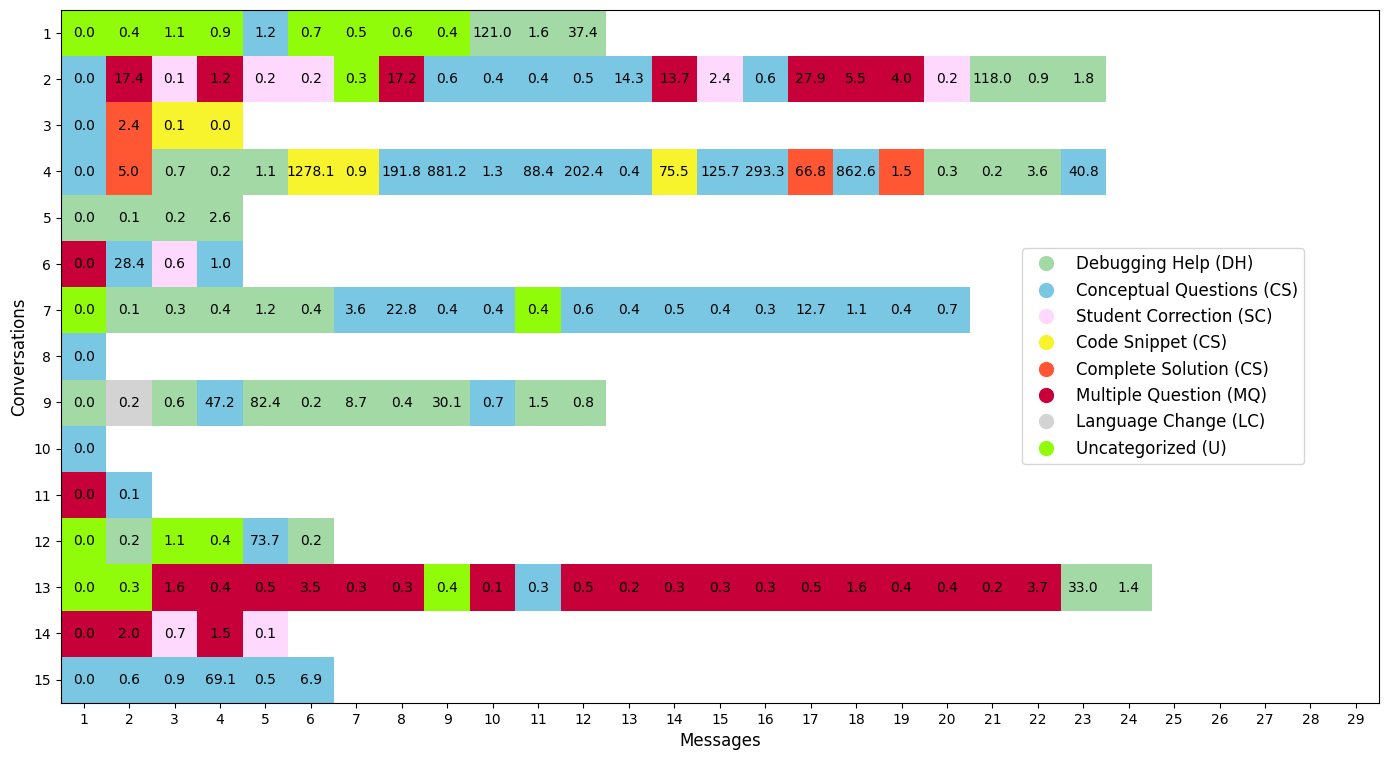

In [9]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to convert hex color codes to RGB format
def hex_to_rgb(hex_value):
    if isinstance(hex_value, float):
        return (255, 255, 255)  # Return white color for float values
    hex_value = hex_value.lstrip('#')  # Remove the hash symbol from the hex code
    return tuple(int(hex_value[i:i+2], 16) for i in (0, 2, 4))  # Convert hex to RGB tuple

# Load the merged CSV file into a DataFrame
df = pd.read_csv('data/merged_result.csv', sep=';')

# Convert 'Datetime' column to datetime using the correct format
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%H:%M:%S - %d/%m/%Y', errors='coerce')

# Filter the DataFrame to only include rows where 'Role' column is 'User'
df = df[df['Role'] == 'User']

# Drop unnecessary columns: 'Role', 'Message', and AI-related columns
df = df.drop(columns=['Role', 'Message', 'AI - 1%', 'AI - 2%', 'AI - 3%', 'AI - 4%'])

# Create a dictionary to map classification labels to their respective color codes
classification_colors = {
    'Debugging Help': '#A3D9A5',
    'Conceptual Questions': '#79C7E3',
    'Student Correction': '#FED9FD',
    'Code Snippet': '#F7F42D',
    'Complete Solution': '#FF5733',
    'Multiple Question Exercise': '#C70039',
    'Language change': '#D3D3D3',
    'Uncategorized': '#91FC09',
}

# Map each 'Classification' in the DataFrame to its corresponding color using the dictionary
df['Color'] = df['Classification'].map(classification_colors)

# Truncate the 'Id' column to the first 10 characters
df['Id'] = df['Id'].str[:10]

# Sort data by 'Id' and 'Datetime' to ensure proper order
df = df.sort_values(by=['Id', 'Datetime'])

# Calculate time differences between each message for each user
df['TimeDelta'] = df.groupby('Id')['Datetime'].diff().fillna(pd.Timedelta(seconds=0))
df['TimeDeltaMinutes'] = df['TimeDelta'].dt.total_seconds() / 60  # Convert to minutes

# Save the modified DataFrame to a new CSV file
df.to_csv('data/merged_result_heatmap_with_time.csv', index=False, sep=';')

# Find the maximum number of messages for any 'Id'
max_len = 0
for key in df['Id'].unique():
    if max_len < df[df['Id'] == key].shape[0]:
        max_len = df[df['Id'] == key].shape[0]

dic_colors = {}
dic_times = {}

# Populate the dictionary with {Id: [color1, color2, ..., colorN]} and time differences
for key in df['Id'].unique():
    row_colors = {key: [color for color in df[df['Id'] == key]['Color']]}
    row_times = {key: [round(time, 1) for time in df[df['Id'] == key]['TimeDeltaMinutes']]}  # Round to 1 decimal
    dic_colors.update(row_colors)
    dic_times.update(row_times)

# >>>>>>> Order dic_colors by number of messages in descending order
#dic_colors = dict(sorted(dic_colors.items(), key=lambda x: len(x[1]), reverse=False))

# Fill the color list with white ('#FFFFFF') and time list with NaN to match the max length
for key in dic_colors.keys():
    dic_colors[key] = dic_colors[key] + ['#FFFFFF'] * (max_len - len(dic_colors[key]))
    dic_times[key] = dic_times[key] + [np.nan] * (max_len - len(dic_times[key]))

# Convert hex color values to RGB format for plotting
for key in dic_colors.keys():
    dic_colors[key] = [hex_to_rgb(color) for color in dic_colors[key]]

# >>>>>>> Uncomment to display the 15 first conversations
dic_colors = dict(list(dic_colors.items())[:15])


# Plot the heatmap with time intervals in the cells
fig, ax = plt.subplots(figsize=(17, 9))  # Aumente o valor de figsize conforme necessário

# Set axis labels
ax.set_xlabel('Messages', fontsize=12)
ax.set_ylabel('Conversations', fontsize=12)

# Set ticks for the x-axis and y-axis
ax.set_xticks(range(max_len))
ax.set_xticklabels(range(1, max_len + 1))  # Definir o rótulo para começar em 1

ax.set_yticks(range(len(dic_colors)))
ax.set_yticklabels(range(1, len(dic_colors) + 1))

# >>>>>>> Uncomment to show the 'Id' values on the y-axis
#ax.set_yticklabels(dic_colors.keys())

# Display the heatmap using the list of RGB color values
heatmap = ax.imshow(list(dic_colors.values()), aspect='auto')

# >>>>>>> Annotate each cell with the time delta in minutes, and use a smaller font size
for i, key in enumerate(dic_colors.keys()):
    for j, time in enumerate(dic_times[key]):
        if not np.isnan(time):  # Annotate only if time is not NaN
            ax.text(j, i, f'{time:.1f}', ha='center', va='center', color='black', fontsize=10)  # Small font

# Create a legend with classification labels and their respective colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=12,
                              label='Debugging Help (DH)' if label == 'Debugging Help' else
                                    'Conceptual Questions (CS)' if label == 'Conceptual Questions' else
                                    'Code Snippet (CS)' if label == 'Code Snippet' else
                                    'Complete Solution (CS)' if label == 'Complete Solution' else
                                    'Multiple Question (MQ)' if label == 'Multiple Question Exercise' else
                                    'Language Change (LC)' if label == 'Language change' else
                                    'Uncategorized (U)' if label == 'Uncategorized' else
                                    'Student Correction (SC)' if label == 'Student Correction' else label)
                   for label, color in classification_colors.items()]

# Position the legend on the right side of the plot with a larger font size
ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.95, 0.5), title='', fontsize='12')

# Show the heatmap plot
plt.show()
